## Imports

In [1]:
import pandas as pd
from statsmodels.stats import multitest
import matplotlib.pyplot as plt
import pandas as pd
from timers import *
import warnings
warnings.filterwarnings("ignore")

print("Done")

Done


## Prepare dataframe

Processing Broodminder weather data.
Reading Broodminder weather data.
Processing Ambient data.
Processing Broodminder data.
Reading Broodminder data.
Done


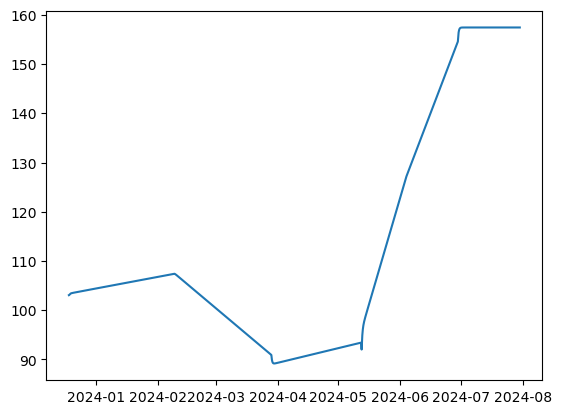

In [2]:
hive_IDs = {"New Left Hive": '6b5cb8b012cb45038eacc24770a2fff7',
            "Utah OW Nuc Left": '13a71f80590a4184a2956058441c3be3',
            "Utah OW Nuc Right": 'dca02aae55b74ca1b1a6ac35042d2254',
           }

Bee_Weather = BeeWeather()
Bee_Weather.set()

ambient = Ambient()
ambient.set()

master_df = pd.DataFrame()

for hive_creds in list(hive_IDs.items()):
    current_hive = Hive(*hive_creds)
    current_hive.set()
    if not current_hive.get_weight().empty:
        master_df = pd.concat([master_df, pd.DataFrame(current_hive.get_weight(interp = 1)).rename(columns={"Weight": "hive_weight"})], axis = 1)
    if not current_hive.get_upper_temp().empty:
        master_df = pd.concat([master_df, pd.DataFrame(current_hive.get_upper_temp(interp = 1)).rename(columns={"Temperature": "hive_upper_temp"})], axis = 1)
    if not current_hive.get_lower_temp().empty:
        master_df = pd.concat([master_df, pd.DataFrame(current_hive.get_lower_temp(interp = 1)).rename(columns={"Temperature": "hive_lower_temp"})], axis = 1)
    if not current_hive.get_humidity().empty:
        master_df = pd.concat([master_df, pd.DataFrame(current_hive.get_humidity(interp = 1)).rename(columns={"Humidity": "hive_humidity"})], axis = 1)
    break

master_df = pd.concat([master_df, Bee_Weather.get_beeweather(interp = 1), ambient.get_ambient(interp = 1)], axis = 1)
master_df.dropna(subset=['hive_weight', 'hive_upper_temp', 'hive_lower_temp', 'hive_humidity'], axis = "rows", how = "all", inplace = True)

master_df = pd.concat([master_df, pd.DataFrame({'Unix_Time': master_df['hive_weight'].dropna().index, "kalman_weight": kalman(master_df['hive_weight'].dropna())}).set_index("Unix_Time")], axis = 1)
master_df = pd.concat([master_df, pd.DataFrame({'Unix_Time': master_df['hive_upper_temp'].dropna().index, "kalman_upper_temp": kalman(master_df['hive_upper_temp'].dropna())}).set_index("Unix_Time")], axis = 1)
master_df = pd.concat([master_df, pd.DataFrame({'Unix_Time': master_df['hive_lower_temp'].dropna().index, "kalman_lower_temp": kalman(master_df['hive_lower_temp'].dropna())}).set_index("Unix_Time")], axis = 1)
master_df = pd.concat([master_df, pd.DataFrame({'Unix_Time': master_df['hive_humidity'].dropna().index, "kalman_humidity": kalman(master_df['hive_humidity'].dropna())}).set_index("Unix_Time")], axis = 1)

fig, ax = plt.subplots()
ax.plot(master_df['hive_weight'].dropna().index,  master_df['kalman_weight'].dropna())

print("Done")

## Create correlation matrix

In [3]:
# dataframe = pd. DataFrame (data = dataset. data, columns = dataset. feature_names)
# dataframe ["target"] = dataset. target

master_df.drop(columns = ['lastRain'], inplace = True)

#correlation matrix
matrix = master_df.corr()

print("Done")

Done


## Bonferroni Correction of calculated p-values

In [4]:
# Calculate adjusted p-values
reject, adj_pvals, _, _ = multitest.multipletests(matrix, method='bonferroni')

print("Done")

Done


## Display correlation matrix

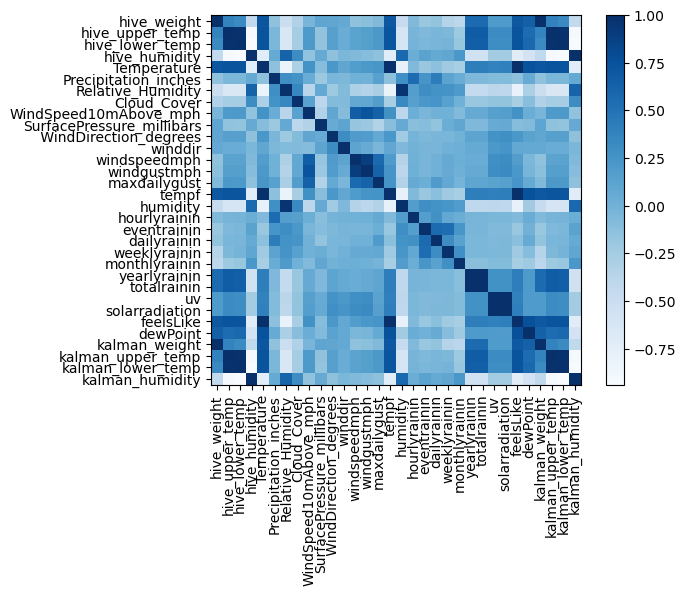

In [5]:
# plotting correlation matrix
plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=90)
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()